# 패키지 다운로드

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings("ignore")

# 데이터 셋 확인

In [4]:
rawdata = pd.read_csv("./구리 공급/공급 변수_최종.csv")
display(rawdata)

# 날짜 데이터를 제외한 나머지값만 data 변수로 저장
data_no_date = rawdata.drop("Date", axis = 1)

,Date,Copper price,Cash Costs,Transport,Stock,Oil Price,M_GDP,PX_LAST
0,2000-01-01,0.855289,0.39,928.60,15868200,25.511000,435.48,1202241.000
1,2000-02-01,0.827855,0.39,928.60,16834150,27.775714,435.48,1155760.000
2,2000-03-01,0.805130,0.39,928.60,18638525,27.486087,435.48,1253977.000
3,2000-04-01,0.776305,0.39,966.68,13103150,22.764444,476.12,1186378.000
4,2000-05-01,0.831318,0.39,966.68,13712200,27.737619,476.12,1238011.000
...,...,...,...,...,...,...,...,...
274,2022-11-01,3.656582,1.27,1811.00,1971200,91.415455,8414.73,2193243.262
275,2022-12-01,3.817891,1.27,1811.00,1696075,80.924000,8414.73,2197474.345
276,2023-01-01,4.118691,1.54,1751.00,1719650,82.501429,6543.48,2306260.603
277,2023-02-01,4.082400,1.54,1751.00,1318875,82.585000,6543.48,2208886.704


# 데이터 표준화

In [5]:
# 원본데이터의 값만 numpy 2차원 배열로 전환
dataset = data_no_date.values

# 행 기준으로 평균, 표준편차를 구해 표준화 진행
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset.shape)

(279, 7)


# 타임 스텝 별 데이터 분리 함수

In [4]:
# dataset: 데이터셋
# target: 종속변수
# start_index: 시작 행 번호
# end_index: 끝 행 번호
# history_size: 학습시킬 데이터의 양
# target_size: 미래 예측할 기간
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    
    data = []
    labels = []
    
    # 데이터 분리를 반복해서 진행할 시작값 설정
    start_index = start_index + history_size
    
    # 데이터 분리를 반복해서 진행할 끝값 설정
    if end_index is None:
        end_index = len(dataset) - target_size

    # 시작값부터 끝값까지 데이터 분리를 반복하는 반복분 설정
    for i in range(start_index, end_index):
        
        # 데이터 분리할 범위 설정
        indices = range(i - history_size, i)
        
        # numpy 2차원 배열에서 데이터 범위만큼 학습 데이터 분리
        data.append(dataset[indices])

        # 종속변수의 미래예측 범위만큼 데이터 분리
        labels.append(target[i:i + target_size])
            
    # 실행 결과값을 numnpy 2차원 배열로 학습데이터와 평가데이터 return
    return np.array(data), np.array(labels)

# 모델 학습 및 검증 손실 변화 시각화 함수

In [5]:
# histroy: 모델 학습 과정 중 epoch마다의 손실율을 저장한 DataFrame
# title: 시각화한 그래프의 제목
def plot_train_history(history, title):
    
    # 모델 학습 시의 손실율 저장
    loss = history.history['loss']
    
    # 모델 평가 시의 손실율 저장
    val_loss = history.history['val_loss']

    # 전체 epochs의 길이 변수로 저장
    epochs = range(len(loss))

    # 손실율 함수 그래프 그리기
    plt.figure()

    ## 학습 손실율
    plt.plot(epochss, loss, 'b', label='Training loss')
    
    ## 평가 손실율
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    ## 그래프 제목
    plt.title(title)
    
    ## 그래프 범례
    plt.legend()

    plt.show()

# 하이퍼 파라매터 설정

In [ ]:
# 학습 데이터의 수 지정
TRAIN_SPLIT = 240

# 모델 학습 시 사용할 데이터의 크기
BATCH_SIZE = 20

# 한 번의 학습에 사용할 배치의 크기
EVALUATION_INTERVAL = 12

# 전체 학습 데이터를 학습 반복 단위
EPOCHS = 50

# 학습할 데이터의 개월 수 지정
past_history = 12

# 예측할 미래의 개월 수 지정
future_target = 6

# 랜덤 시드 고정
tf.random.set_seed(13)

# 타임 스텝별 독립변수와 종속변수 추출

In [7]:
# 학습데이터 분리
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -1], 0, TRAIN_SPLIT, past_history, future_target)

# 평가데이터 분리
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -1], TRAIN_SPLIT, None, past_history, future_target)

# 분리된 데이터의 차원 확인
print("--- 학습데이터 확인 ---")
print(x_train_multi.shape)
print(y_train_multi.shape)

print("--- 평가데이터 확인 ---")
print(x_val_multi.shape)
print(y_val_multi.shape)

print("--- 데이터 분리 확인 ---")
print('학습할 과거의 차원 확인 : {}'.format(x_train_multi[0].shape))
print('예측할 미래의 개월 수 확인 : {}'.format(y_train_multi[0].shape))

(228, 12, 7)
(228, 6)
(21, 12, 7)
(21, 6)
Single window of past history : (12, 7)
Target temperature to predict : (6,)


# 학습 및 평가 데이터 추출

In [231]:
# 데이터 shuffle할 때 할당할 버퍼의 크기(크기가 클수록 한번에 많은 데이터를 shuffle하지만 메모리를 많이 잡아먹음)
BUFFER_SIZE = 10000

# 학습데이터를 tensorflow의 데이터셋으로 변환
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# 모델 학습 성능향상을 위해 학습데이터를 캐싱
# BUFFER_SIZE만큼 데이터를 shuffle
# BATCH_SIZE만큼 데이터를 하나로 묶음
# repeat()를 통해 학습할 데이터의 양을 늘림
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# 평가데이터를 tensorflow의 데이터셋으로 변환
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

# BATCH_SIZE만큼 데이터를 하나로 묶음
# repeat()를 통해 학습할 데이터의 양을 늘림
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# LSTM 모델 구축 및 학습

Epoch 1/50
12/12 [==============================] - 7s 96ms/step - loss: 0.6351 - val_loss: 1.3989
Epoch 2/50
12/12 [==============================] - 0s 14ms/step - loss: 0.4841 - val_loss: 1.2969
Epoch 3/50
12/12 [==============================] - 0s 13ms/step - loss: 0.4062 - val_loss: 1.0263
Epoch 4/50
12/12 [==============================] - 0s 14ms/step - loss: 0.3001 - val_loss: 0.7841
Epoch 5/50
12/12 [==============================] - 0s 14ms/step - loss: 0.2285 - val_loss: 0.6120
Epoch 6/50
12/12 [==============================] - 0s 14ms/step - loss: 0.1707 - val_loss: 0.4547
Epoch 7/50
12/12 [==============================] - 0s 14ms/step - loss: 0.1540 - val_loss: 0.5517
Epoch 8/50
12/12 [==============================] - 0s 13ms/step - loss: 0.1403 - val_loss: 0.4441
Epoch 9/50
12/12 [==============================] - 0s 13ms/step - loss: 0.1353 - val_loss: 0.4467
Epoch 10/50
12/12 [==============================] - 0s 14ms/step - loss: 0.1320 - val_loss: 0.4615
Epoch 11/

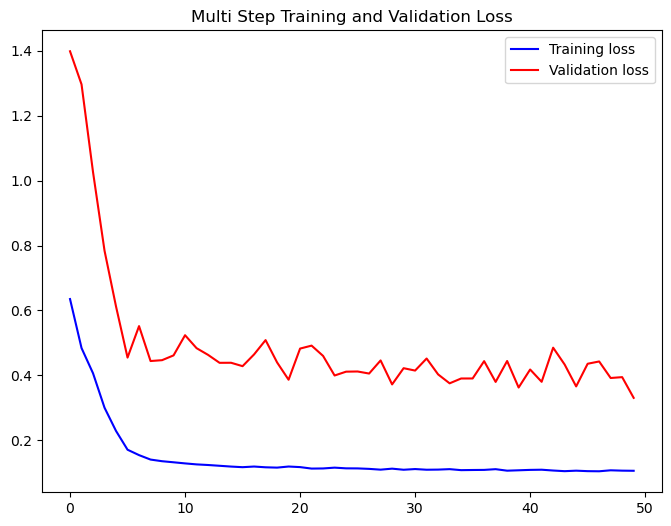

In [232]:
# 모델 정의
multi_step_model = tf.keras.models.Sequential()

# LSTM 레이어 추가
## BATCH_SIZE와 입력값을 동일하게 설정
## 레이어 추가를 위해 출력 시퀀스를 반환하도록 설정
## 입력값을 학습데이터의 차원(2차원, 12행 6열)으로 설정
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))

# LSTM 레이어 추가
## 활성화함수 ReLU 사용: 모델에 비선형성을 추가하여 복잡한 패턴 학습 가능
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))

# 출력 레이어 추가
## 예측할 개월 수만큼 뉴런의 개수 설정
multi_step_model.add(tf.keras.layers.Dense(6)) 

# 모델의 학습방법 설정
## optimizer: RMSprop(경사하강법)
## clipvalue를 1로 설정하여 그라디언트값의 발산범위를 제한하여 학습성능을 높임
## 손실함수: MAE(평균절대오차)
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

# 모델 학습
## train_data_multi: tensorflow 데이터셋으로 된 학습데이터
## epochs: 모델 학습을 50회 반복해서 진행
## steps_per_epoch: 한 에폭당 16개의 배치를 사용
## validation_data: 평가데이터
## validation_steps: 1번의 에폭 진행 후 평가 진행
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=1)

# 손실함수 그래프 그리기
plot_train_history(multi_step_history, 'Multi Step Training and Validation Loss')

# 예측 결과 시각화

In [9]:
# 원본데이터 불러오기
temp_df = rawdata

# 종속변수 표준화
MOVING_MEAN = temp_df["PX_LAST"].mean(axis=0)
MOVING_STD = temp_df["PX_LAST"].std(axis=0)
temp_df["PX_LAST_STD"] = (temp_df["PX_LAST"] - MOVING_MEAN) / MOVING_STD

# 표준화된 종속변수 9개월치 지수이동평균선 그리기
temp_df["PX_LAST_STD_EWM"] = temp_df["PX_LAST_STD"].ewm(span=9, adjust=False).mean()

# 날짜데이터 index로 설정
temp_df.index = temp_df["Date"]
temp_df = temp_df.drop("Date", axis = 1)

temp_df

,Copper price,Cash Costs,Transport,Stock,Oil Price (Dollars per Barrel),M_GDP,PX_LAST,PX_LAST_STD,PX_LAST_STD_EWM
Date,,,,,,,,,
2000-01-31,0.855289,0.39,928.60,15868200,25.511000,435.48,1202241.000,-1.557966,-1.557966
2000-02-29,0.827855,0.39,928.60,16834150,27.775714,435.48,1155760.000,-1.712537,-1.588880
2000-03-31,0.805130,0.39,928.60,18638525,27.486087,435.48,1253977.000,-1.385919,-1.548288
2000-04-30,0.776305,0.39,966.68,13103150,22.764444,476.12,1186378.000,-1.610718,-1.560774
2000-05-31,0.831318,0.39,966.68,13712200,27.737619,476.12,1238011.000,-1.439013,-1.536422
...,...,...,...,...,...,...,...,...,...
2022-11-30,3.656582,1.27,1811.00,1971200,91.415455,8414.73,2193243.262,1.737588,1.616067
2022-12-31,3.817891,1.27,1811.00,1696075,80.924000,8414.73,2197474.345,1.751658,1.643185
2023-01-31,4.118691,1.54,1751.00,1719650,82.501429,6543.48,2306260.603,2.113424,1.737233


In [10]:
# 전 기간 데이터 학습데이터로 분리하기
x_full_multi, y_full_multi = multivariate_data(dataset, dataset[:, -1], 0, None, past_history, future_target)

# (1995.01 - 1995.12) ~ (2021.6 - 2022.5)
print(x_full_multi.shape)

temp_list = []

temp_list.append(dataset[261:273])
temp_list.append(dataset[262:274])
temp_list.append(dataset[263:275])
temp_list.append(dataset[264:276])
temp_list.append(dataset[265:277])
temp_list.append(dataset[266:278])
temp_list.append(dataset[267:279])

temp_array = np.array(temp_list)
print("---------------")
print(temp_array.shape)

x_full_multi = np.append(x_full_multi, temp_array, axis = 0)
print("---------------")
print(x_full_multi.shape)

In [15]:
# 전체 기간 데이터를 tensorflow 데이터셋으로 전환
full_data_multi = tf.data.Dataset.from_tensor_slicesces(x_full_multi)

# BATCH_SIZE를 지정하고 이를 한번만 반복되게 설정
full_data_multi = full_data_multi.batch(BATCH_SIZE).repeat(1)

# 학습한 모델을 통해 미래 데이터를 예측
predict = multi_step_model.predict(full_data_multi)

14/14 [==============================] - 1s 3ms/step


In [16]:
# 예측한 6개월치의 데이터 중 첫 번째 값만 가져오고, 마지막값은 6개월치를 다 가져옴
predict_list = []

for i in range(len(predict)):
    predict_list.append(predict[i][0])
    
    if i == (len(predict) - 1):
        for j in predict[i][1:]:
            predict_list.append(j)
            
len(predict_list)

273

In [17]:
# 2000년 1월부터 2023년 3월까지의 데이터를 학습하여
# 2001년 1월부터 2023년 9월까지의 데이터를 예측

# index에 활용할 월별 datetime값 설정
predict_index = pd.date_range(start='2001-01-01', end='2023-10-01', freq='M')

# 예측값을 DataFrame으로 생성
df_pre = pd.DataFrame(temp_list, index=predict_index, columns=["Predict"])

# 예측값의 9개월치 지수이동평균값 계산
df_pre["Predict_EWM"] = df_pre["Predict"].ewm(span=9, adjust=False).mean()

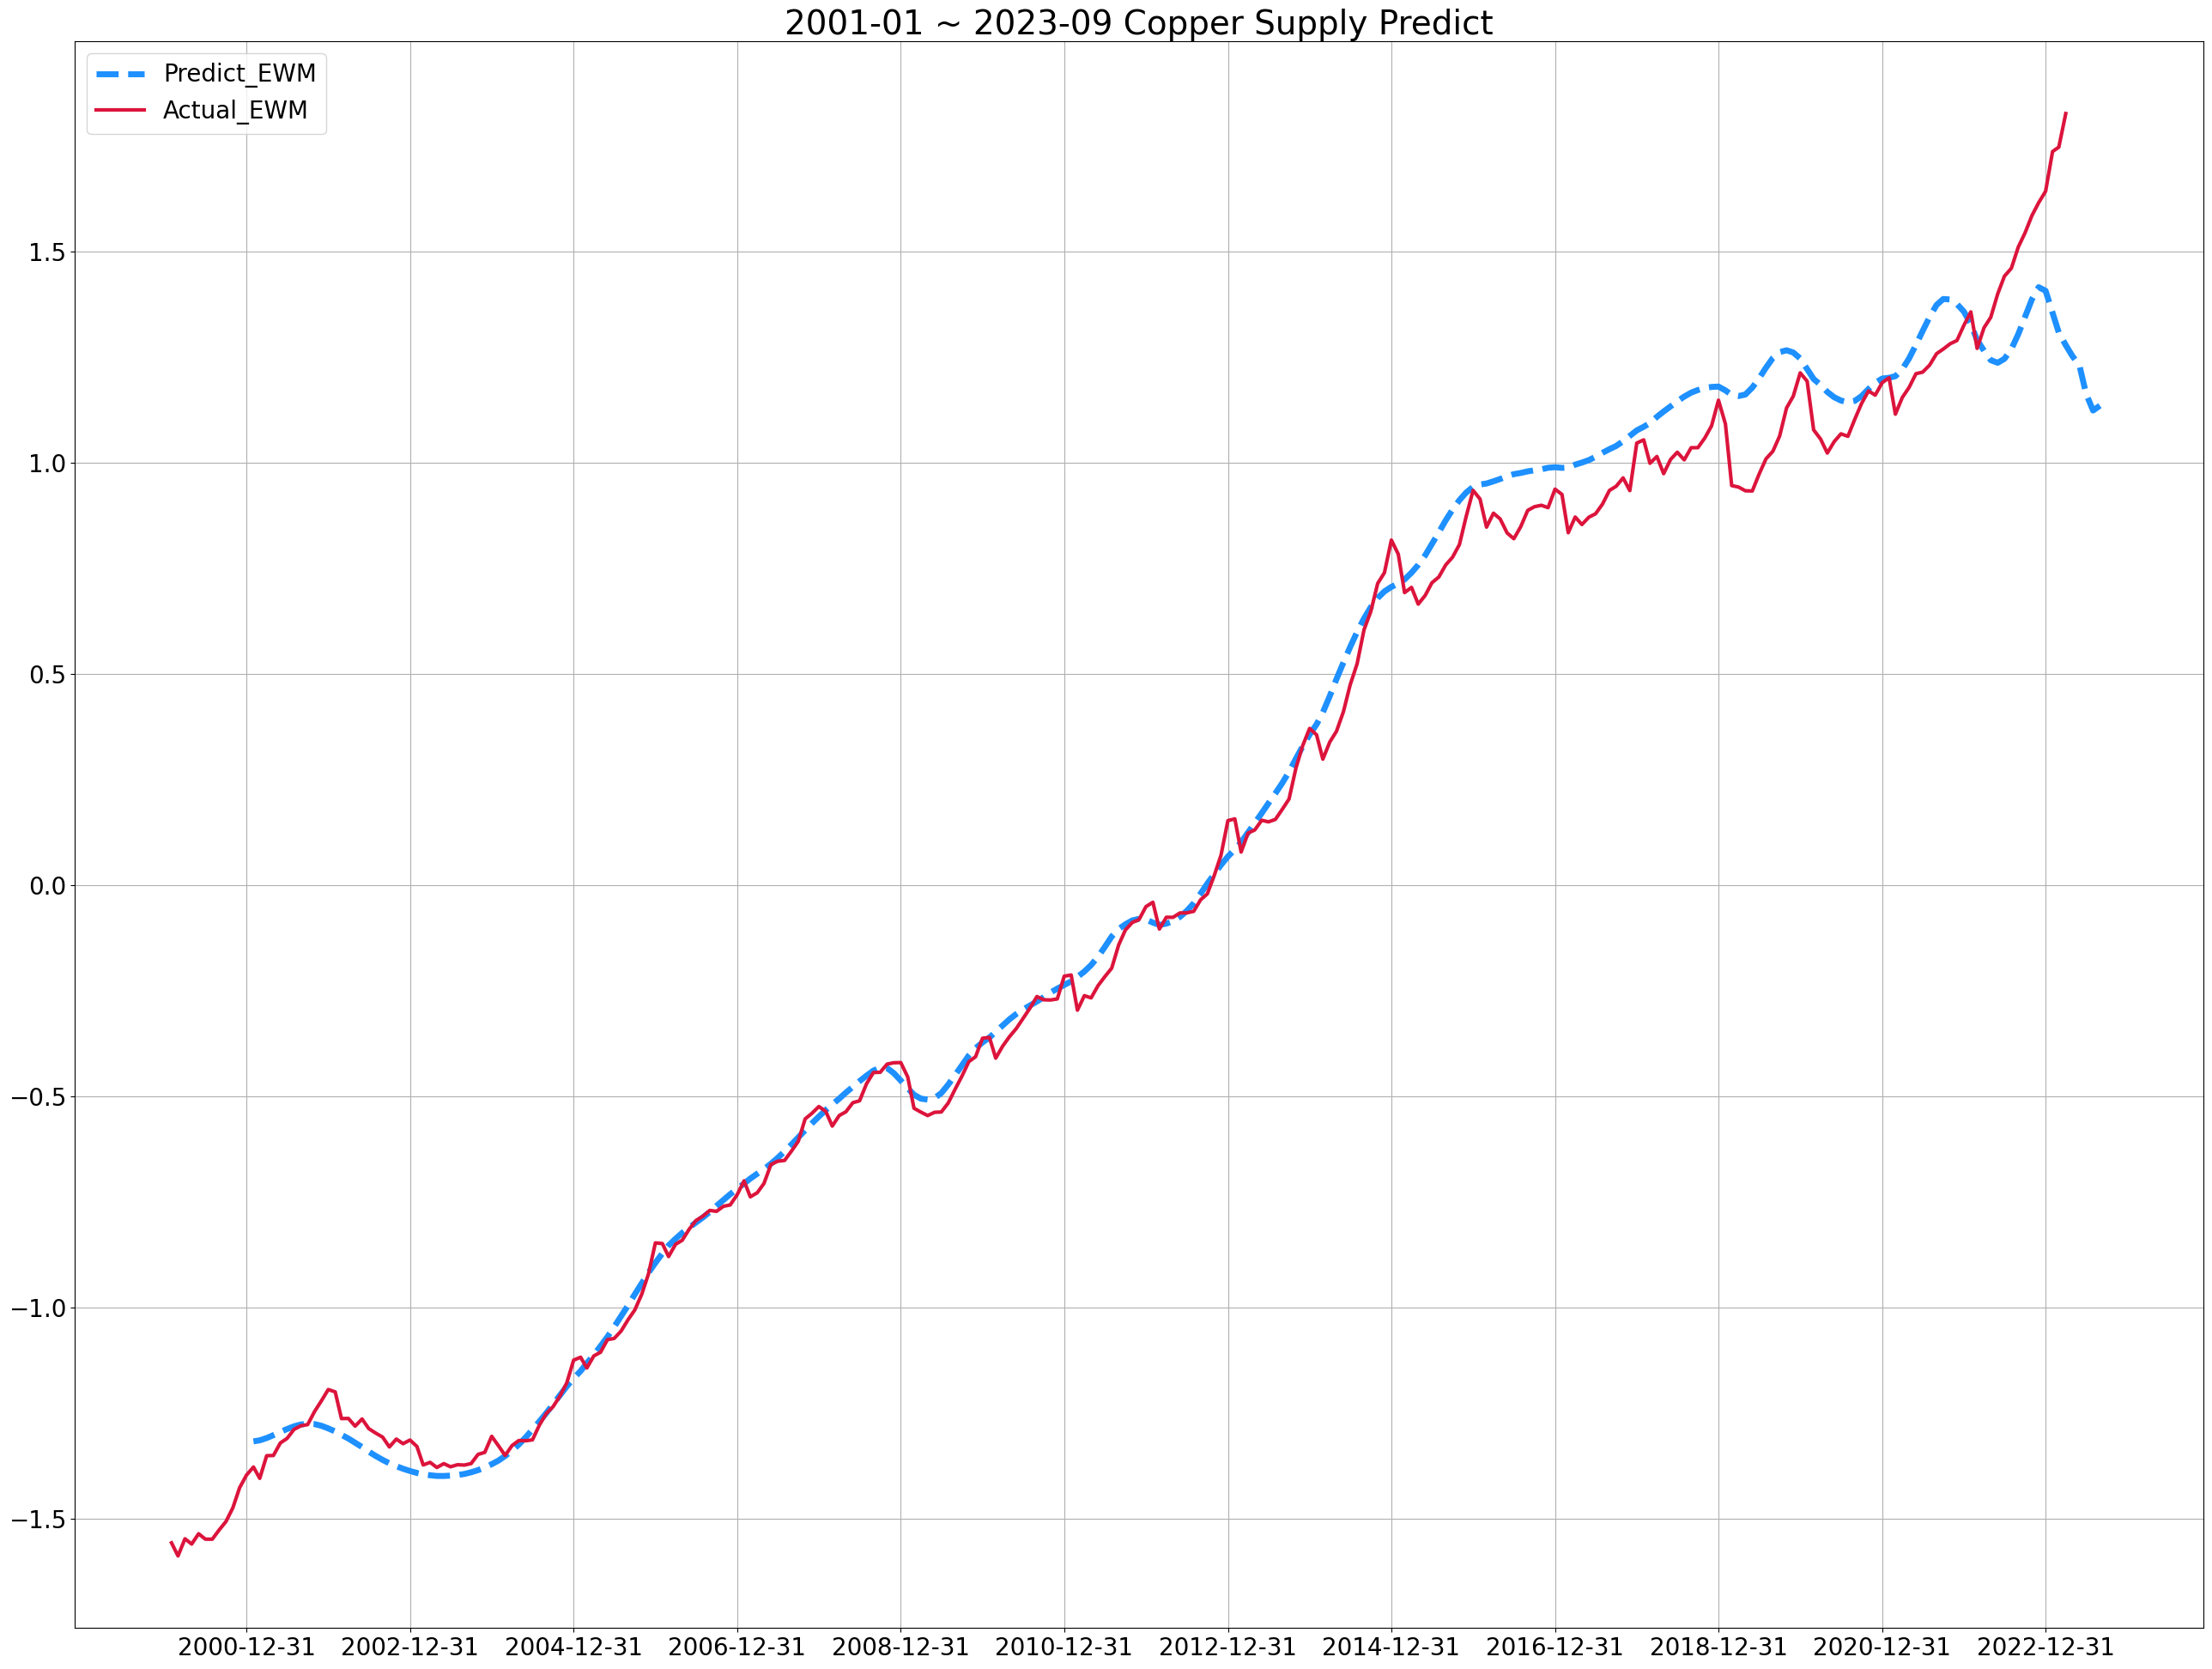

In [18]:
# 그래프 크기
plt.figure(figsize=(32,24))

# 예측값
plt.plot(df_pre["Predict_EWM"], color='dodgerblue', ls='--', lw='5')

# 실제값
plt.plot(temp_df["PX_LAST_STD_EWM"], color='crimson', lw='3')

# 그래프 제목
plt.title("2001-01 ~ 2023-09 Copper Supply Predict", size=28)

# 그래프 범례
plt.legend(["Predict_EWM", "Actual_EWM"], prop={'size': 20})

# x축 눈금 단위, 글자 크기 설정
plt.xticks(pd.date_rangeange("2000", "2023", freq = "2Y"), size=20)

# y축 눈금 글자 크기 설정
plt.yticks(size=20)

# 그래프 격자
plt.grid()

plt.show()

In [20]:
final= pd.concat([df_pre["Predict_EWM"], temp_df["PX_LAST_STD_EWM"]], axis = 1)
final.to_csv("./구리 공급/2차 모델 데이터_공급.csv")

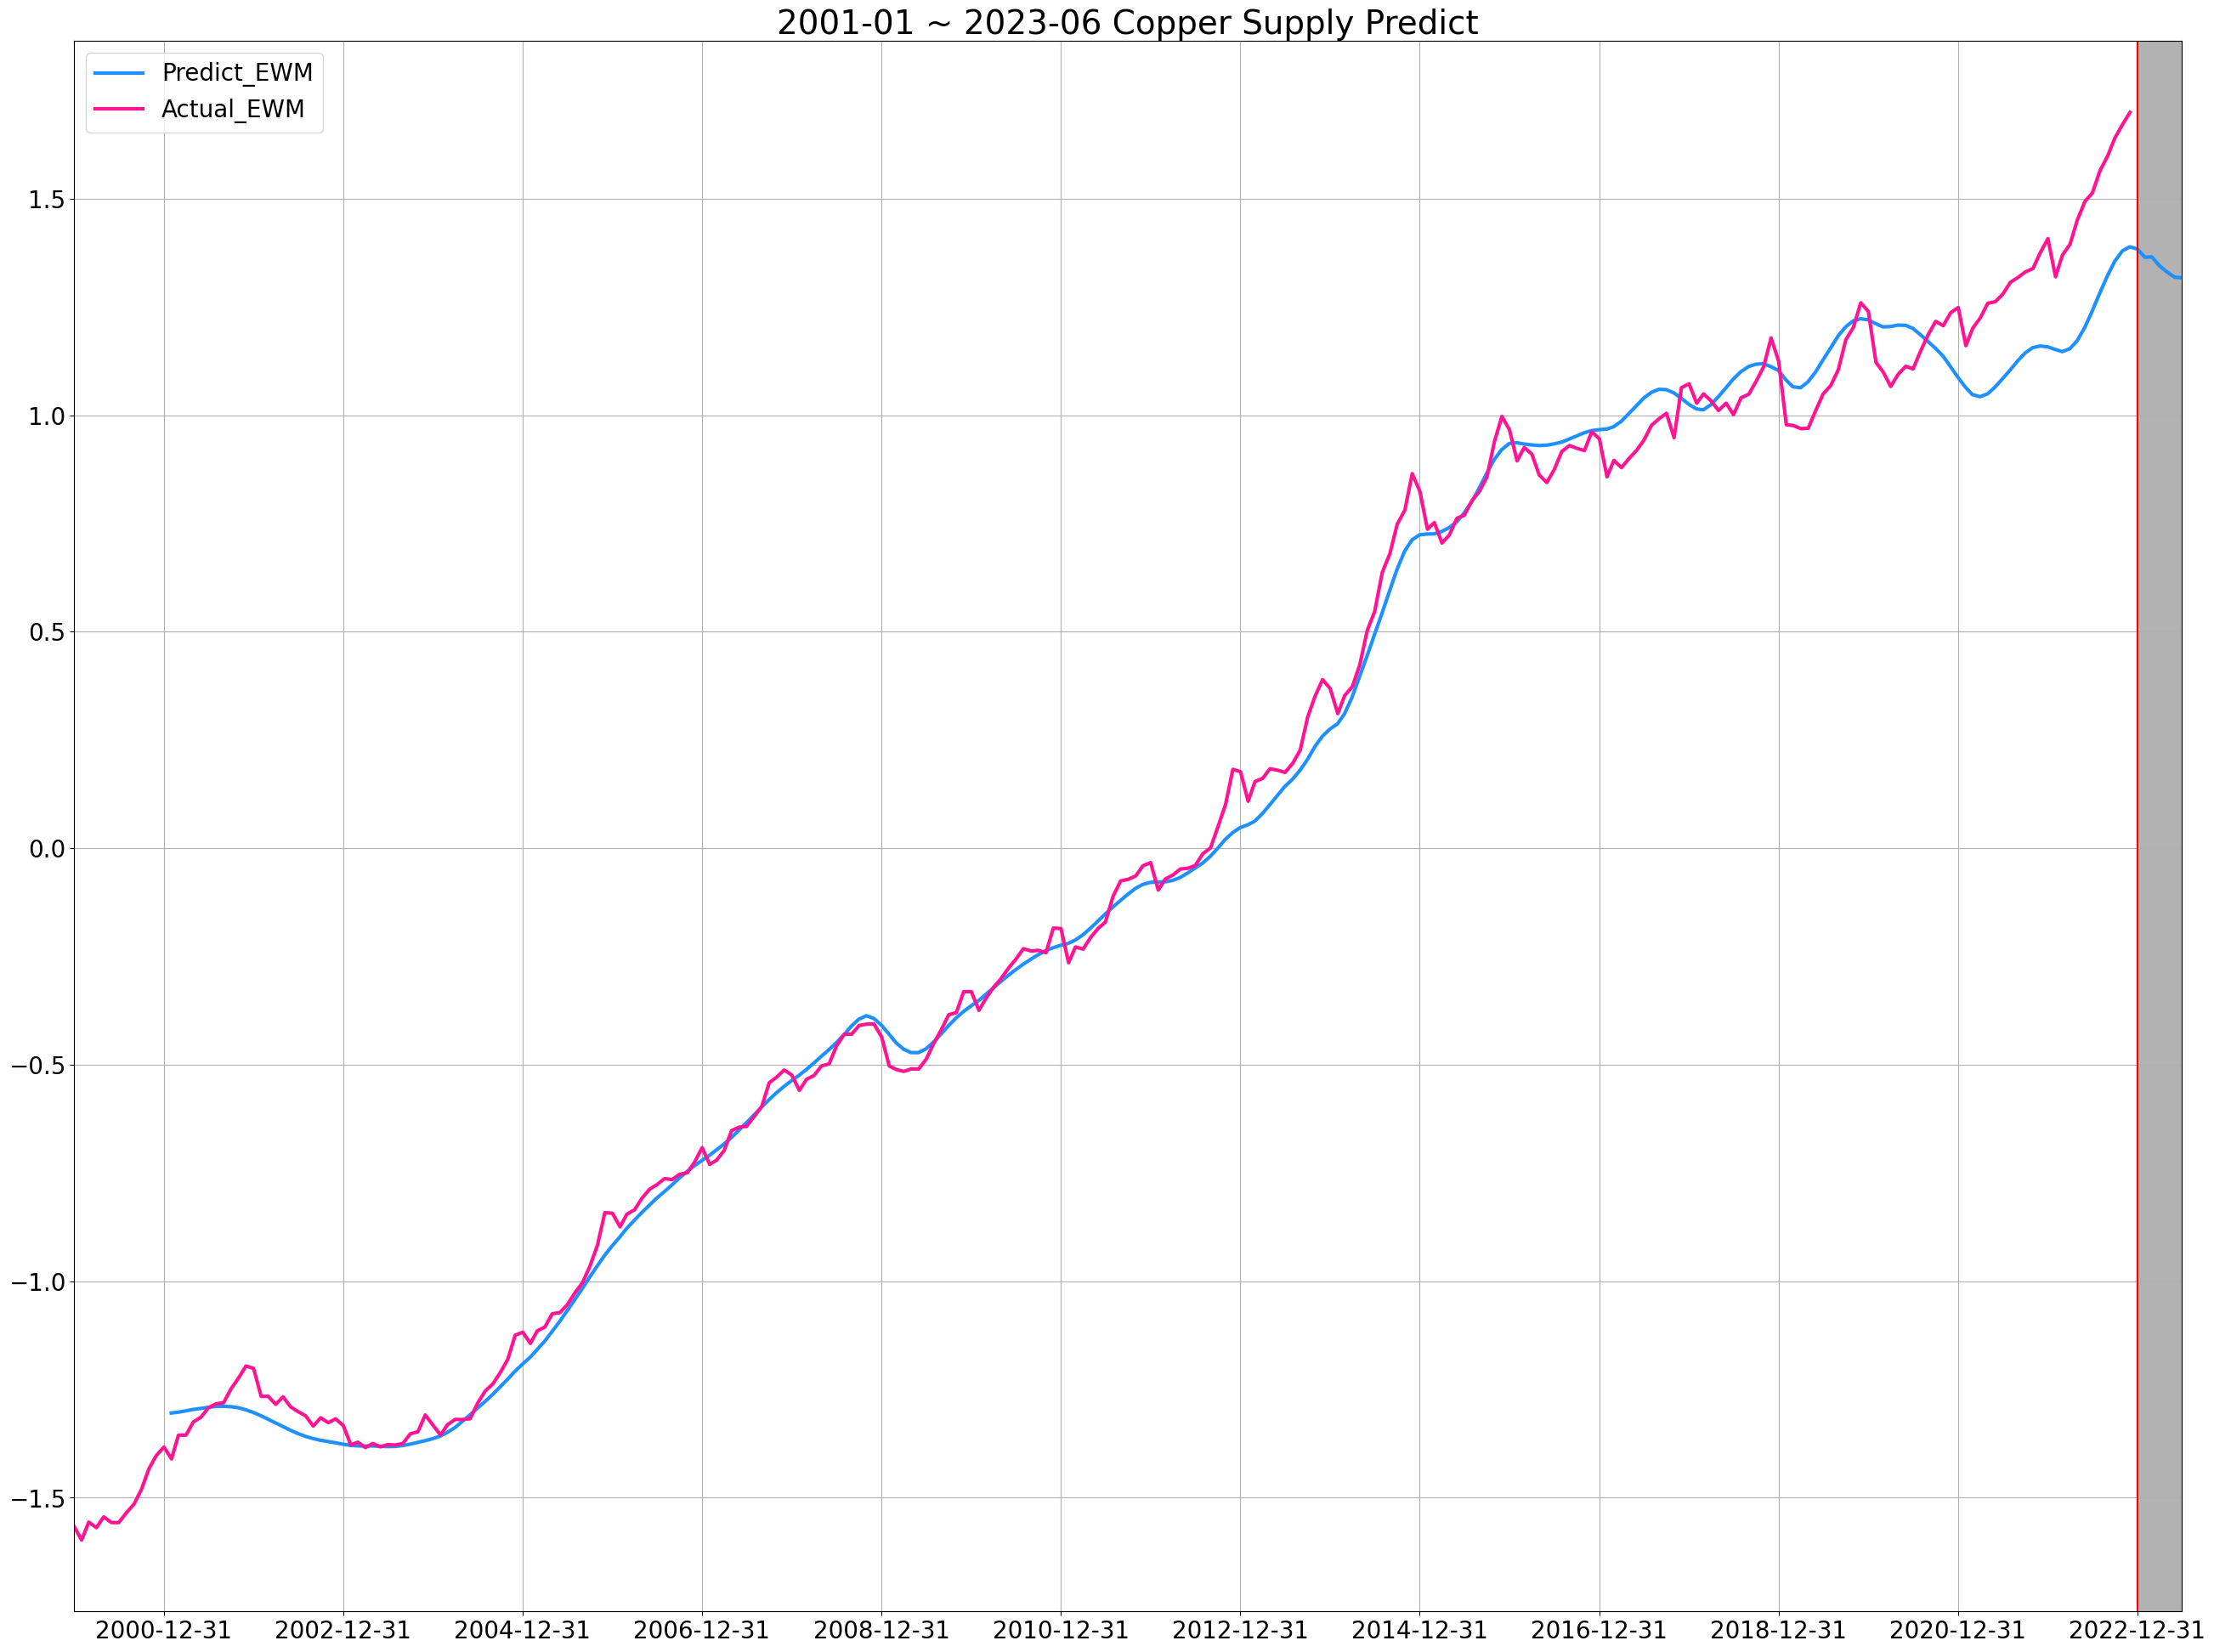

In [69]:
plt.figure(figsize=(32,24))

plt.plot(df_pre["Predict_EWM"], color='dodgerblue', lw='3')
plt.plot(total["PX_LAST_STD_EWM"], color='deeppink', lw='3')

plt.title("2001-01 ~ 2023-06 Copper Supply Predict", size=28)

# plt.legend(["Predict", "Predict_EWM", "Actual_EWM"])
plt.legend(["Predict_EWM", "Actual_EWM"], prop={'size': 20})
plt.xticks(pd.date_range("2000", "2023", freq = "2Y"), size=20)
plt.yticks(size=20)
plt.axvline(pd.to_datetime("2022-12-31"), color='red', lw='1.5')
plt.axvspan(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-06-30"), facecolor='gray', alpha=0.6)
plt.xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2023-06-30"))

plt.grid()
plt.show()

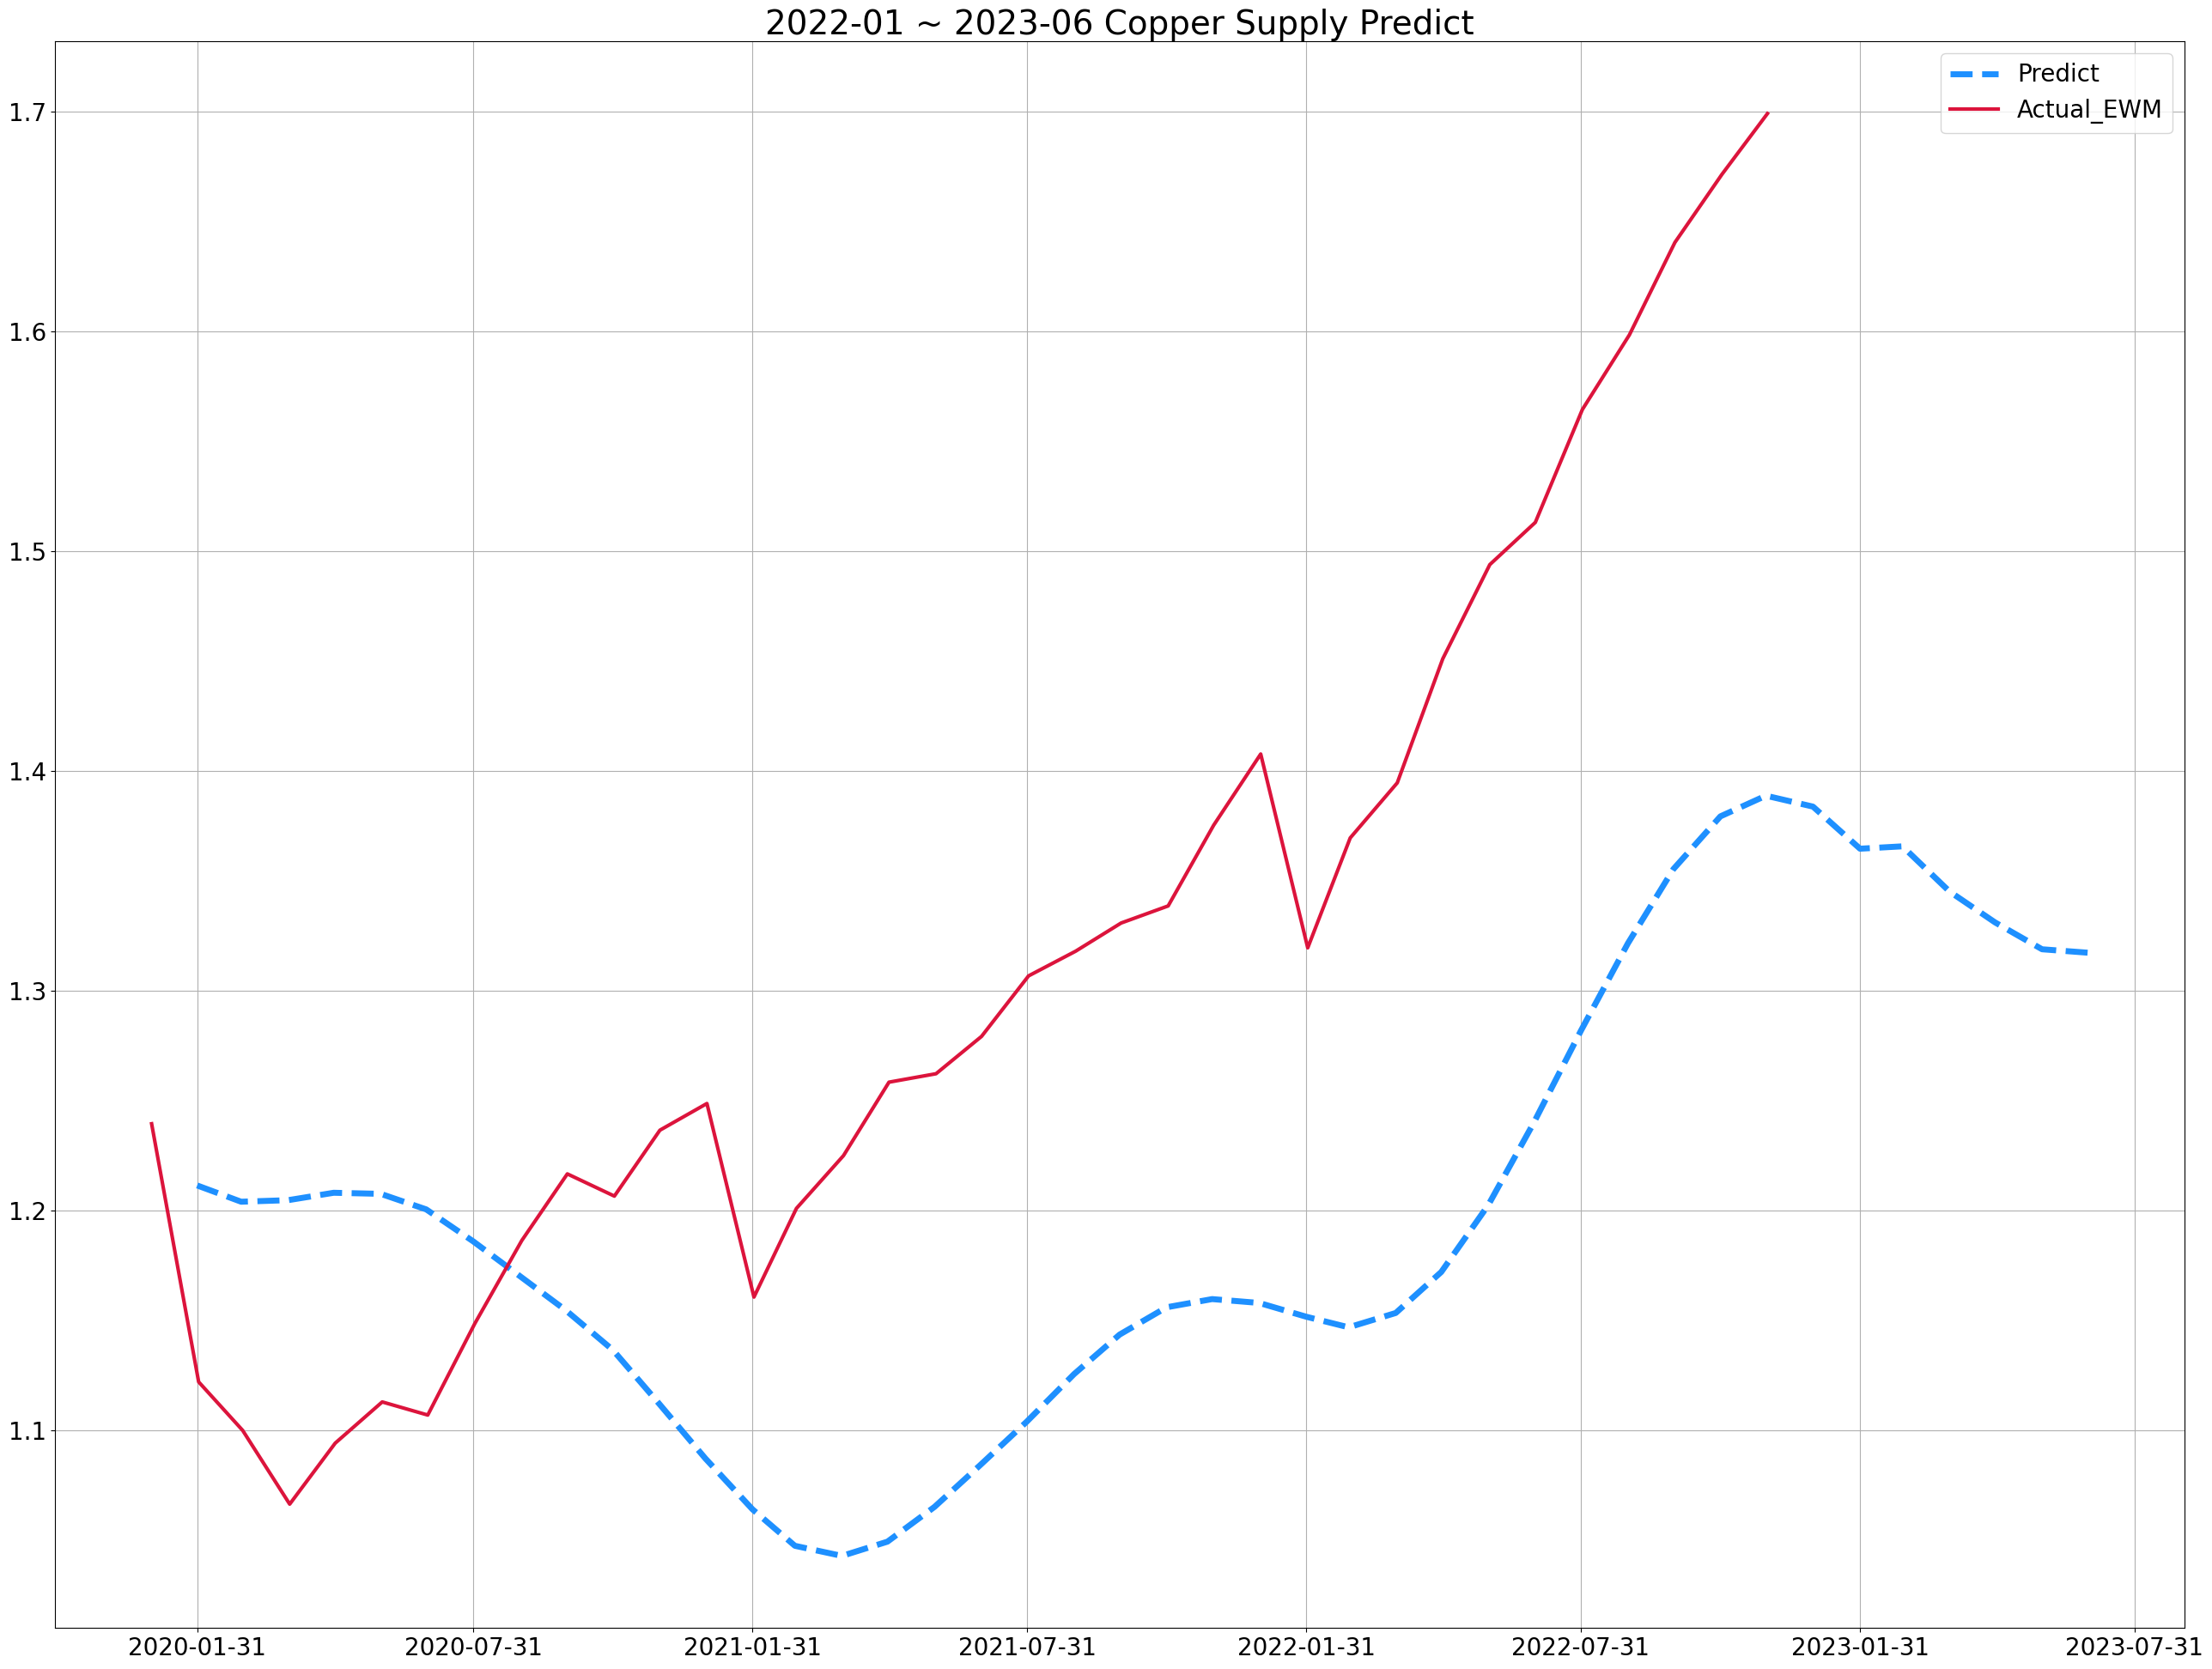

In [57]:
plt.figure(figsize=(32,24))

plt.plot(df_pre["Predict_EWM"][-42:], color='dodgerblue', ls='--', lw='5')
plt.plot(total["PX_LAST_STD_EWM"][-36:], color='crimson', lw='3')

plt.title("2022-01 ~ 2023-06 Copper Supply Predict", size=28)

plt.legend(["Predict", "Actual_EWM"], prop={'size': 20})
plt.xticks(pd.date_range("2020", "2024", freq = "6M"), size=20)
plt.yticks(size=20)

plt.grid()
plt.show()

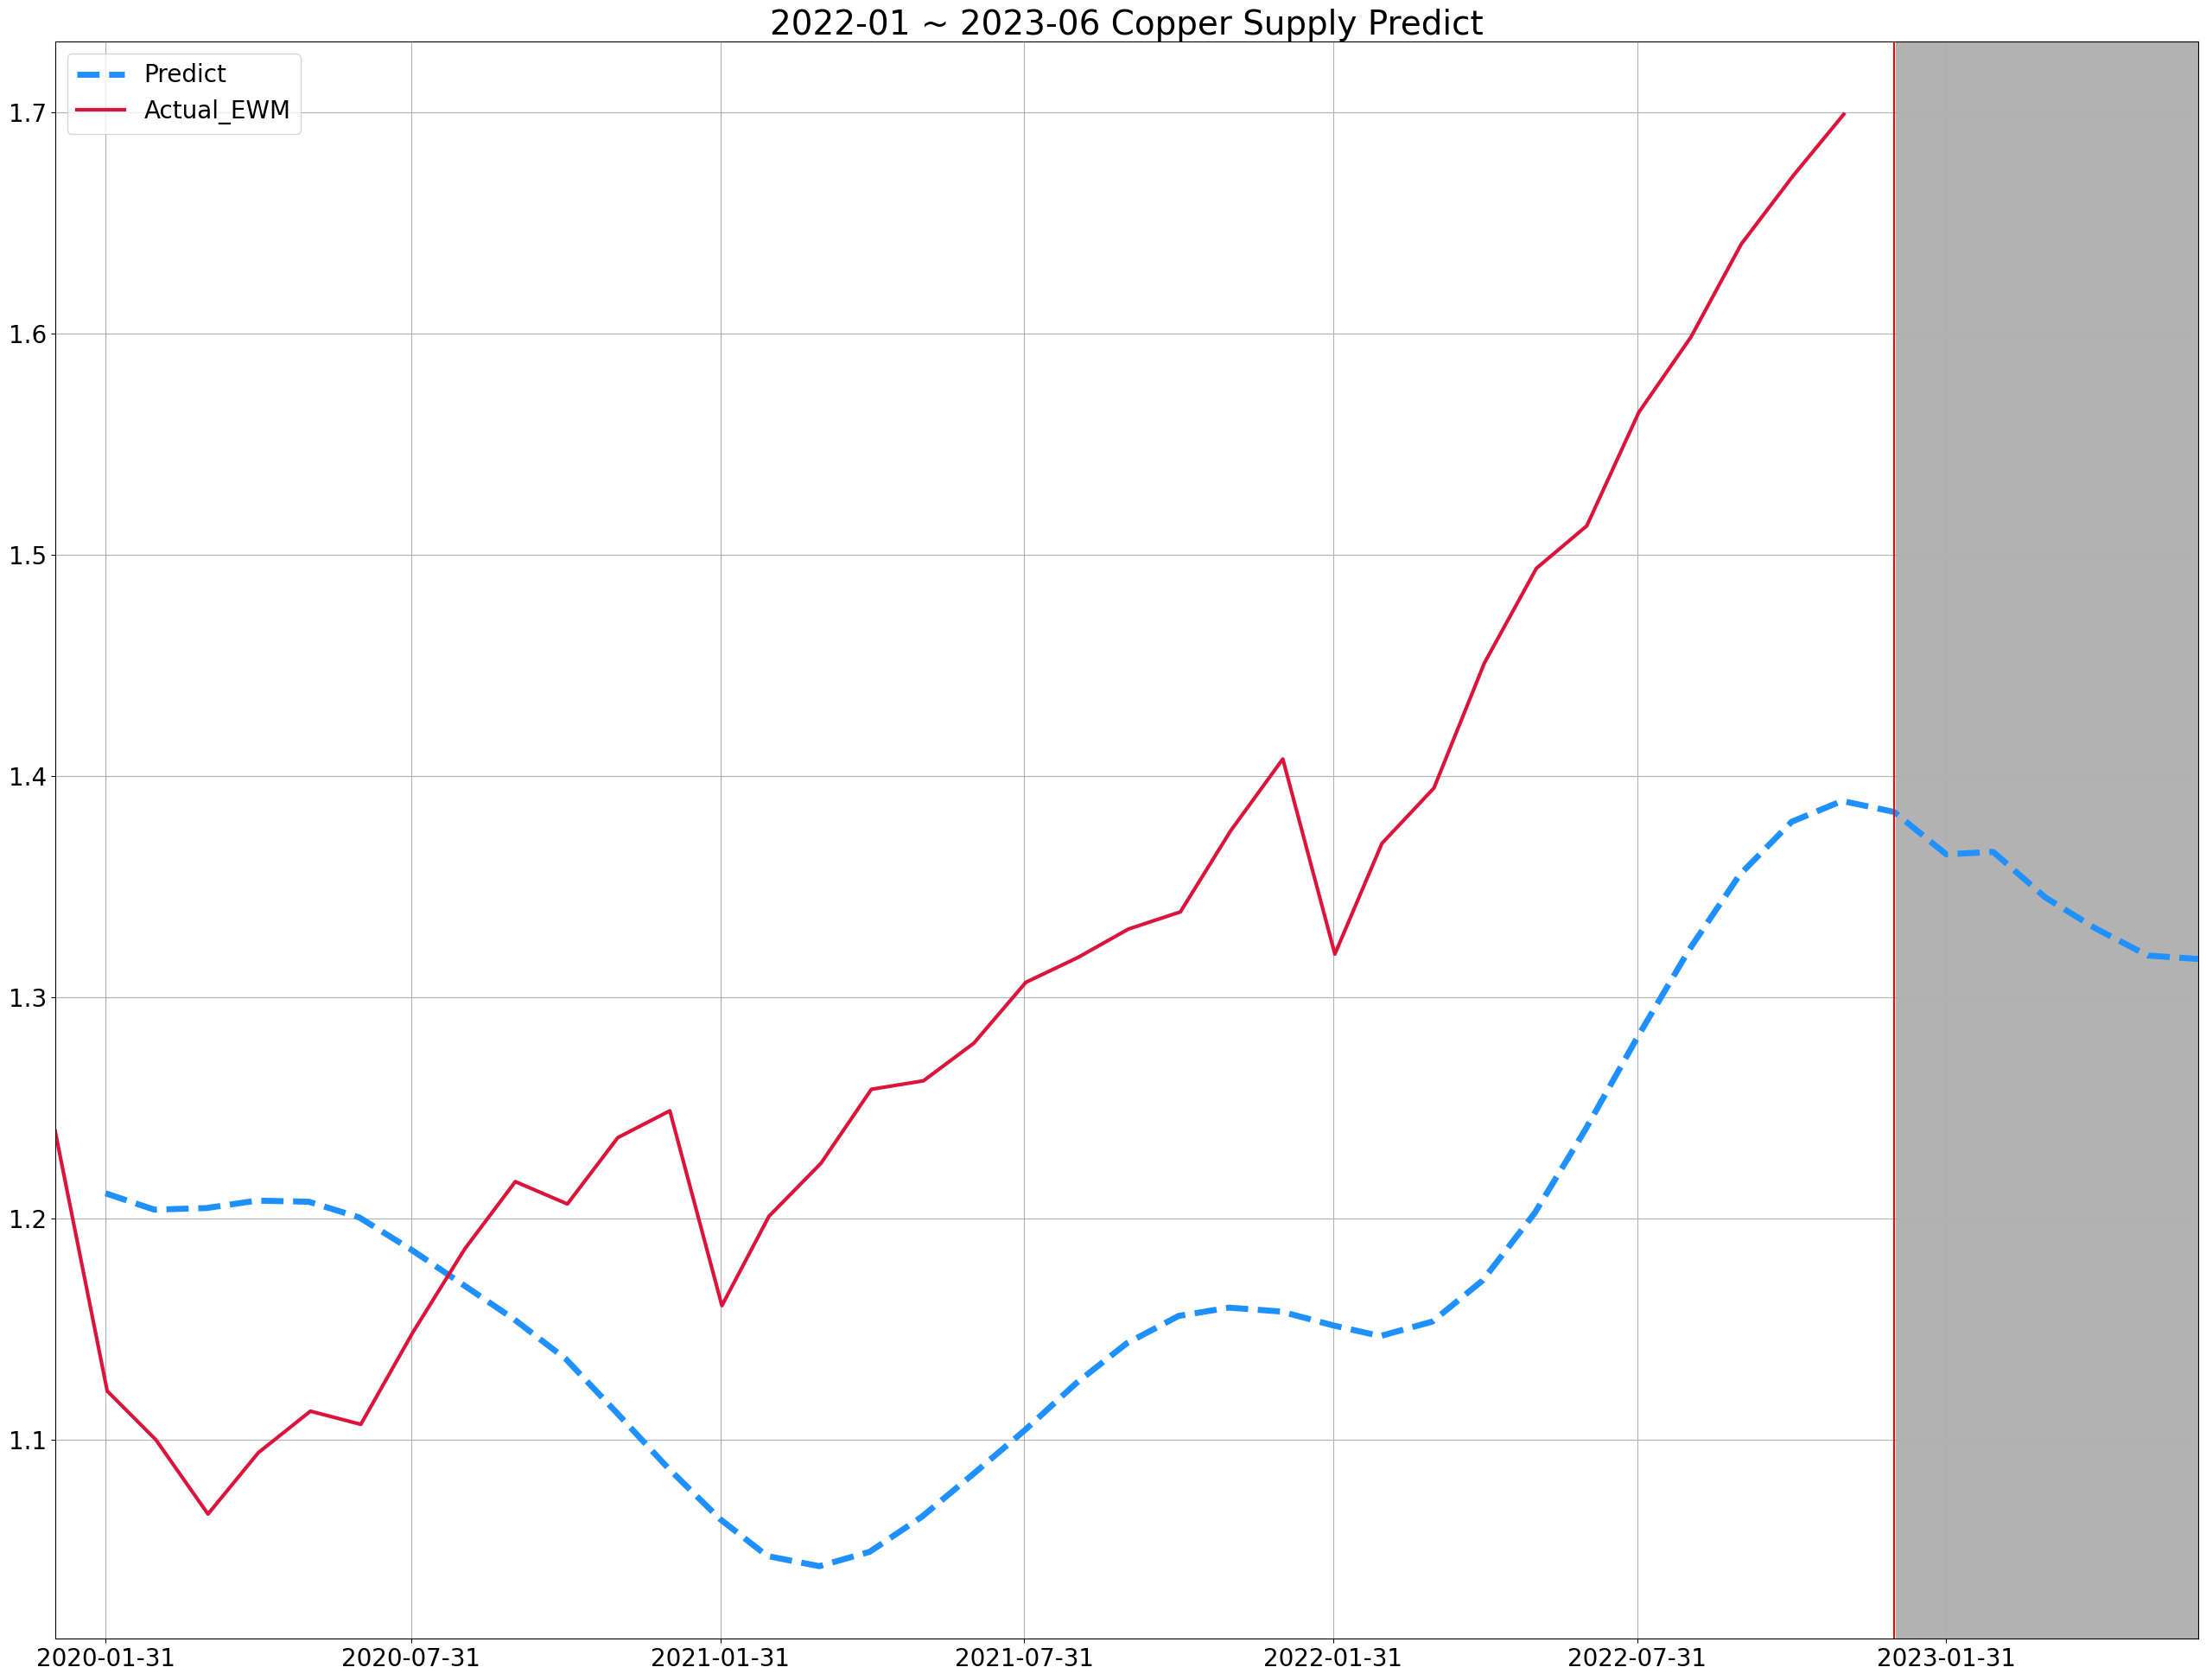

In [71]:
plt.figure(figsize=(32,24))

plt.plot(df_pre["Predict_EWM"][-42:], color='dodgerblue', ls='--', lw='5')
plt.plot(total["PX_LAST_STD_EWM"][-36:], color='crimson', lw='3')

plt.axvspan(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-06-30"), facecolor='gray', alpha=0.6)
plt.axvline(pd.to_datetime("2022-12-31"), color='red', lw='1.5')
plt.xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2023-06-30"))

plt.xticks(pd.date_range("2020-01-01", "2023-07-01", freq = "6M"), size=20)
plt.yticks(size=20)

plt.title("2022-01 ~ 2023-06 Copper Supply Predict", size=28)
plt.legend(["Predict", "Actual_EWM"], prop={'size': 20})
plt.grid()
plt.show()

# 모델 저장 및 결과 저장

In [243]:
from keras.models import load_model

multi_step_model.save('./구리 공급/공급모델_최종.h5')

# df_pre.to_csv("./수요공급 합치기/0328_2004_구리 공급 예측.csv")

# 모델 불러오기

In [8]:
from keras.models import load_model

multi_step_model = load_model('./구리 공급/공급모델_최종.h5')